# MODELO KMEANS PARA CLASIFICACIÓN DE CLIENTES
## FUENTE : [KAGGLE](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?resource=download)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dev0914sharma/customer-clustering")

print("Path to dataset files:", path)

100%|██████████| 25.9k/25.9k [00:00<00:00, 27.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dev0914sharma/customer-clustering/versions/1


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/dev0914sharma/customer-clustering/versions/1/segmentation data.csv'

In [ ]:
df = pd.read_csv(dataset_path)
df.head(4)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1


# EDA

In [ ]:
df.dtypes

,0
ID,int64
Sex,int64
Marital status,int64
Age,int64
Education,int64
Income,int64
Occupation,int64
Settlement size,int64


# VERIFICAMOS NULOS Y DUPLICADOS

In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.shape

(2000, 8)

# BUSCAMOS OUTLIERS

In [ ]:
from scipy.stats import zscore

z_scores = df.apply(zscore)

outliers = (z_scores.abs() > 3).sum()

outliers

,0
ID,0
Sex,0
Marital status,0
Age,11
Education,36
Income,31
Occupation,0
Settlement size,0


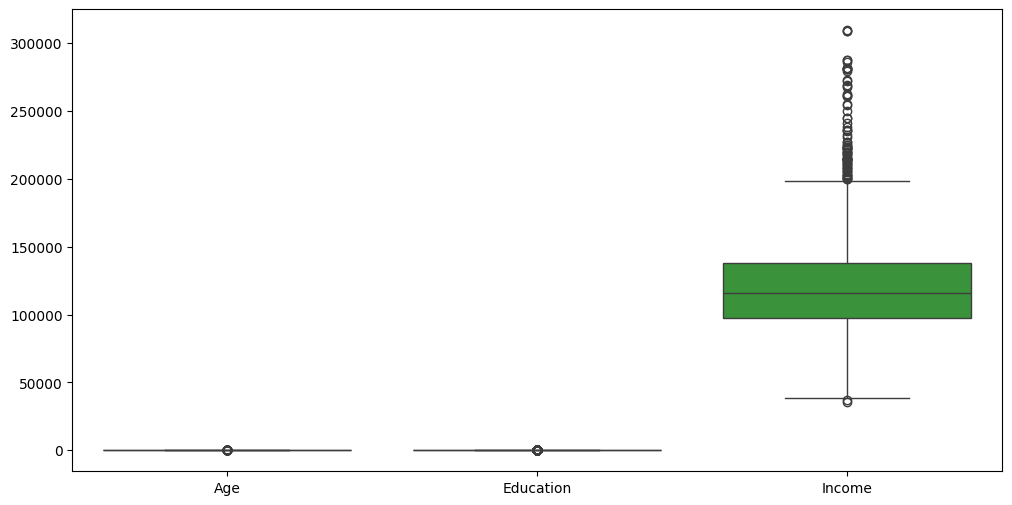

In [ ]:
plt.figure(figsize=(12,6))

sns.boxplot(data=df[['Age','Education','Income']])
plt.show()

In [ ]:
df_cleaned = df[
    (z_scores['Age'].abs() <= 3) &
    (z_scores['Education'].abs() <= 3) &
    (z_scores['Income'].abs() <= 3)
].copy()
df_cleaned.shape

(1926, 8)

# ELIMINAMOS COLUMNAS INNECESARIAS

In [ ]:
df_cleaned.drop(columns=['ID'],inplace=True)
df_cleaned.head(5)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


# ESCALAMOS VALORES

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned),columns=df_cleaned.columns)
df_scaled.head(5)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0.0,0.0,0.924528,1.0,0.452885,0.5,1.0
1,1.0,1.0,0.075472,0.5,0.585955,0.5,1.0
2,0.0,0.0,0.584906,0.5,0.272115,0.0,0.0
3,0.0,0.0,0.509434,0.5,0.691950,0.5,0.5
4,0.0,0.0,0.660377,0.5,0.577075,0.5,0.5


# APLICANDO MODELO KMEANS

## BUSCAMOS EL NÚMERO OPTIMO DE CLUSTERS USANDO METODO DEL CODO(ELBOW)

## Método del Codo en K-Means

Es una técnica para encontrar el número óptimo de clusters en **K-Means** analizando cómo disminuye la inercia.

### Concepto clave:
- La **inercia** (Suma de errores cuadráticos, SSE) mide la compacidad de los clusters.  
- A medida que \( k \) aumenta, la inercia disminuye (los clusters se vuelven más pequeños y ajustados).  
- Sin embargo, después de cierto punto, agregar más clusters **no reduce significativamente la inercia**.


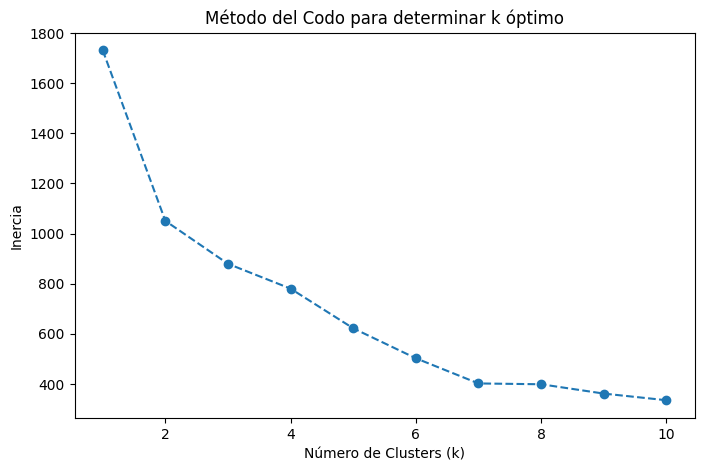

In [19]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(1,11)

for k in k_values:
  kmeans = KMeans(n_clusters=k,random_state=42)
  kmeans.fit(df_scaled)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k óptimo')
plt.show()

## PARA ESTE CASO EL K OPTIMO SERIA 4

In [20]:
from sklearn.metrics import silhouette_score

In [21]:
k = 4
kmeans = KMeans(n_clusters=k,random_state=42,n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_
X_scaled = df_scaled.to_numpy()
silhouette_value = silhouette_score(X_scaled,labels)
print(f'Coeficiente de Silueta para k={k} : {silhouette_value}:.4f')

Coeficiente de Silueta para k=4 : 0.3839308792834323:.4f


# APLICAMOS DISTINTOS PARAMETROS PARA OPTIMIZAR EL MODELO

In [23]:
import itertools
# Valores a probar
def best_kmeans_params(X):
  X_scaled = X
  n_clusters_options = range(2, 20)
  init_options = ['k-means++', 'random']
  max_iter_options = [300, 500]
  tol_options = [1e-4, 1e-5, 1e-3]
  n_init_options = [10, 15]
  algorithm_options = ['lloyd', 'elkan']

  # Todas las combinaciones posibles de parámetros
  param_combinations = list(itertools.product(n_clusters_options, init_options, max_iter_options, tol_options, n_init_options, algorithm_options))

  best_silhouette = -1
  best_params = None
  silhouette_scores = {}

  # Probar todas las combinaciones
  for n_clusters, init, max_iter, tol, n_init, algorithm in param_combinations:
      try:
          kmeans = KMeans(
              n_clusters=n_clusters,
              init=init,
              max_iter=max_iter,
              tol=tol,
              n_init=n_init,
              algorithm=algorithm,
              random_state=42
          )
          kmeans.fit(X_scaled)
          labels = kmeans.labels_
          silhouette = silhouette_score(X_scaled, labels)

          if n_clusters not in silhouette_scores:
              silhouette_scores[n_clusters] = []
          silhouette_scores[n_clusters].append(silhouette)

          print(f'n_clusters={n_clusters}, init={init}, max_iter={max_iter}, tol={tol}, n_init={n_init}, algorithm={algorithm} -> Silhouette: {silhouette:.4f}')

          if silhouette > best_silhouette:
              best_silhouette = silhouette
              best_params = (n_clusters, init, max_iter, tol, n_init, algorithm)
      except Exception as e:
          print(f'Error con parámetros n_clusters={n_clusters}, init={init}, max_iter={max_iter}, tol={tol}, n_init={n_init}, algorithm={algorithm}: {e}')

  # Mostrar mejor combinación
  print("\nMejores parámetros encontrados:")
  print(f'n_clusters={best_params[0]}, init={best_params[1]}, max_iter={best_params[2]}, tol={best_params[3]}, n_init={best_params[4]}, algorithm={best_params[5]} -> Mejor Silhouette: {best_silhouette:.4f}')

  # Graficar coeficiente de silueta
  avg_silhouette_scores = {k: np.mean(v) for k, v in silhouette_scores.items()}
  n_clusters_list = sorted(avg_silhouette_scores.keys())
  silhouette_values = [avg_silhouette_scores[k] for k in n_clusters_list]

  plt.figure(figsize=(8, 5))
  plt.plot(n_clusters_list, silhouette_values, marker='o', linestyle='-', color='b')
  plt.xlabel('Número de Clusters')
  plt.ylabel('Coeficiente de Silueta Promedio')
  plt.title('Coeficiente de Silueta para distintos valores de K')
  plt.grid()
  plt.show()

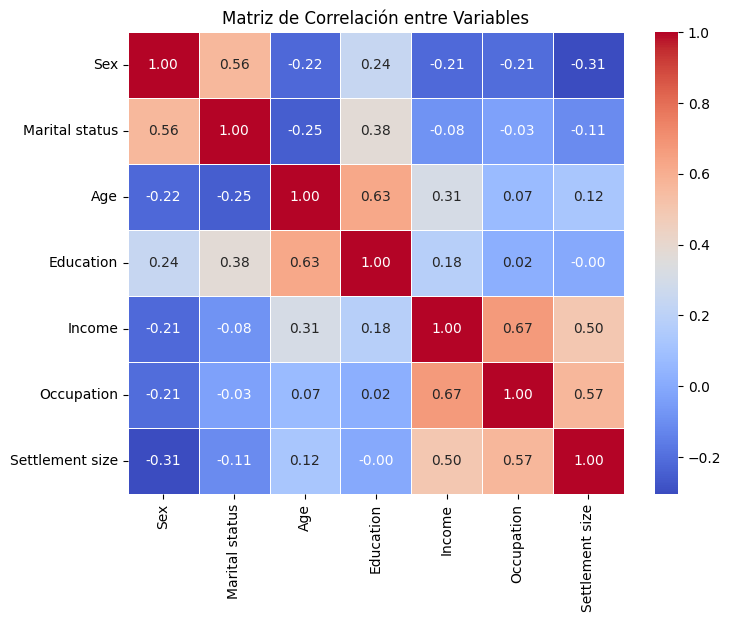

In [22]:
corr_matrix = df_scaled.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

In [24]:
df_scaled.columns

Index(['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation',
       'Settlement size'],
      dtype='object')

In [27]:
df_reduced = df[['Age', 'Education', 'Income', 'Occupation']].copy()
df_reduced

,Age,Education,Income,Occupation
0,67,2,124670,1
1,22,1,150773,1
2,49,1,89210,0
3,45,1,171565,1
4,53,1,149031,1
...,...,...,...,...
1995,47,1,123525,0
1996,27,1,117744,1
1997,31,0,86400,0
1998,24,1,97968,0


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_reduced_scaled = pd.DataFrame(scaler.fit_transform(df_reduced),columns=df_reduced.columns)
df_reduced_scaled.head(5)

,Age,Education,Income,Occupation
0,0.844828,0.666667,0.324781,0.5
1,0.068966,0.333333,0.420210,0.5
2,0.534483,0.333333,0.195144,0.0
3,0.465517,0.333333,0.496223,0.5
4,0.603448,0.333333,0.413842,0.5


n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=10, algorithm=lloyd -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=10, algorithm=elkan -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=15, algorithm=lloyd -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=15, algorithm=elkan -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=10, algorithm=lloyd -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=10, algorithm=elkan -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=15, algorithm=lloyd -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=15, algorithm=elkan -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=0.001, n_init=10, algorithm=lloyd -> Silhouette: 0.4339
n_clusters=2, init=k-means++, max_iter=300, tol=0.001, n_ini

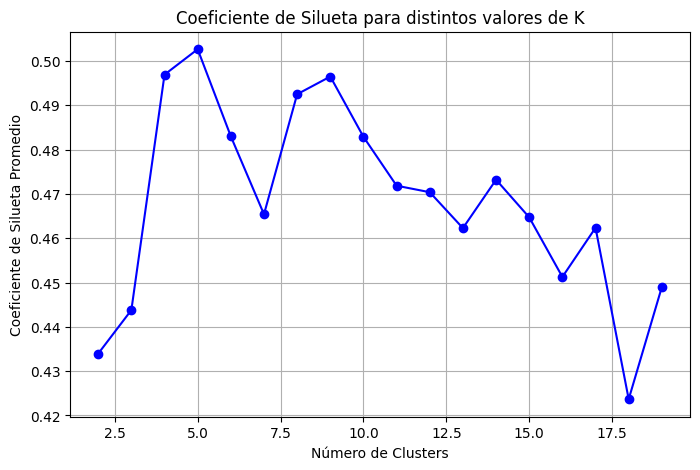

In [29]:
X = df_reduced_scaled.to_numpy()
best_kmeans_params(X)

In [30]:
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, tol=0.0001, n_init=10, algorithm='lloyd',random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
silhouette = silhouette_score(X, labels)
silhouette

np.float64(0.5084172440543347)

# USO DE PCA(ANALISIS DE COMPONENTES PRINCIPALES)

PCA es una técnica que:

- **Encuentra combinaciones lineales de las variables originales** (llamadas componentes principales) para capturar la mayor variabilidad posible.  
- **Reduce la cantidad de dimensiones** manteniendo la mayor cantidad de información posible.  
- **Ayuda en la visualización** cuando los datos tienen muchas variables.  
- **Elimina colinealidad** en los datos, útil para modelos de clustering o aprendizaje automático.  

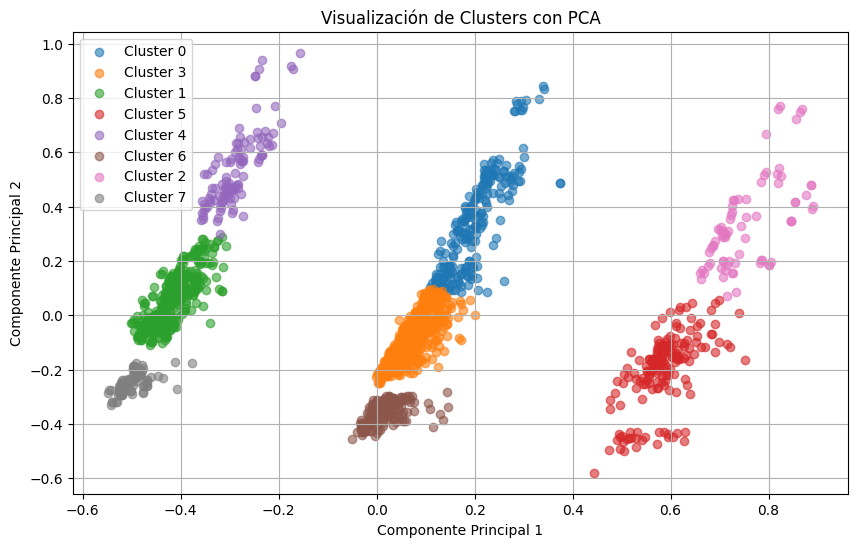

In [ ]:
from sklearn.decomposition import PCA

df_reduced_scaled['Cluster'] = labels
# Reducir dimensiones a 2D usando PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_reduced_scaled.drop(columns=["Cluster"]))

# Convertir a DataFrame y agregar etiquetas de cluster
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = df_reduced_scaled["Cluster"]

# Graficar los clusters
plt.figure(figsize=(10, 6))
for cluster in df_pca["Cluster"].unique():
    subset = df_pca[df_pca["Cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de Clusters con PCA")
plt.legend()
plt.grid()
plt.show()
